In [67]:
%matplotlib inline

In [68]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import functools
import tensorflow as tf
plt.rc('grid', alpha=0)

# Explore cifar-10 data

Let's start by downloading and extracting the binary cifar-10 data.

In [3]:
%bash
wget https://www.cs.toronto.edu/~kriz/cifar-10-binary.tar.gz

converted 'https://www.cs.toronto.edu/~kriz/cifar-10-binary.tar.gz' (ANSI_X3.4-1968) -> 'https://www.cs.toronto.edu/~kriz/cifar-10-binary.tar.gz' (UTF-8)
--2017-07-13 02:21:15--  https://www.cs.toronto.edu/~kriz/cifar-10-binary.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170052171 (162M) [application/x-gzip]
Saving to: 'cifar-10-binary.tar.gz'

     0K .......... .......... .......... .......... ..........  0%  702K 3m57s
    50K .......... .......... .......... .......... ..........  0% 1.58M 2m50s
   100K .......... .......... .......... .......... ..........  0% 17.8M 1m56s
   150K .......... .......... .......... .......... ..........  0% 22.5M 89s
   200K .......... .......... .......... .......... ..........  0% 1.62M 91s
   250K .......... .......... .......... .......... ..........  0% 41.1M 77s
   300K .......

In [4]:
%bash
tar -xvf cifar-10-binary.tar.gz

cifar-10-batches-bin/
cifar-10-batches-bin/data_batch_1.bin
cifar-10-batches-bin/batches.meta.txt
cifar-10-batches-bin/data_batch_3.bin
cifar-10-batches-bin/data_batch_4.bin
cifar-10-batches-bin/test_batch.bin
cifar-10-batches-bin/readme.html
cifar-10-batches-bin/data_batch_5.bin
cifar-10-batches-bin/data_batch_2.bin


In [5]:
labels = !cat cifar-10-batches-bin/batches.meta.txt
labels = labels[:-1] # there's an extra newline at the end of the file
print(labels)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


Let's try loading an example from the first batch of test data. Each example consists of 1 label byte followed by 3072  bytes of image data. Note that there is not delimiter to separate examples.

In [6]:
def get_examples(filename):
  f = open(filename)
  d = { # use a dict because python2 doesn't have python3's nonlocal
    'limit' : 10000,
    'call_count' : 0
   }
  
  def get_example(f):
    if d['call_count'] == d['limit']:
      print('file already closed')
    lbyte = f.read(1)
    ibytes = f.read(3072) 
    # 1st byte is a label, which should be an index in our list of values
    label = np.fromstring(lbyte, dtype='>u1')[0]
    # next 3072 bytes are rgb values ordered like this 1024 R, 1024 G, 1024 B
    # first 32 bytes are the first row of red bytes, next 32 is the second row of red bytes and so on for the 1024 red bytes
    arr = np.frombuffer(ibytes, dtype='>u1')
    arr = arr.reshape(3,32,32)
    # need to swap axes twice because imgplot expects 3, 32, 32 shape
    arr = arr.swapaxes(0,2).swapaxes(0,1)
    d['call_count'] +=1
    if d['call_count'] == d['limit']:
      f.close()
    return labels[label], arr
  
  return functools.partial(get_example, f)

In [7]:
get_next_example = get_examples('cifar-10-batches-bin/data_batch_1.bin')

frog


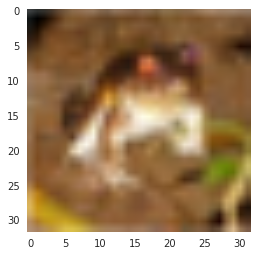

In [8]:
label, arr = get_next_example()
print(label)
imgplot = plt.imshow(arr)

note : `plt.imshow` uses top left corner as the origin

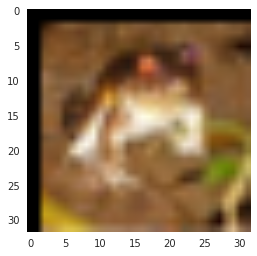

In [9]:
#set top and left sides to 0s
arr.setflags(write=1)
arr[0:2]=0
arr[:,0:2]=0
imgplot = plt.imshow(arr)

# Stop
You can take a moment here to play around with the the images. Try calling get_next_example a few times and looking at the images and labels. Look at another binary if you like.

# Tensorflow Augmenting Image Data with TensorFlow utilities
TensorFlow provides a number of ops you can use to transform images. The cifar-10 example uses them to "augment" the training data by randomly distorting it. Let's try out some of these ops.

truck


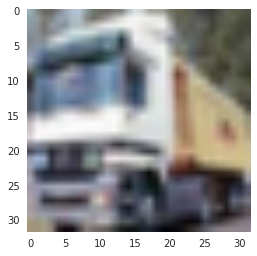

In [10]:
label, arr = get_next_example()
print(label)
imgplot = plt.imshow(arr)

In [11]:
sess = tf.InteractiveSession() # run these in an interactive session

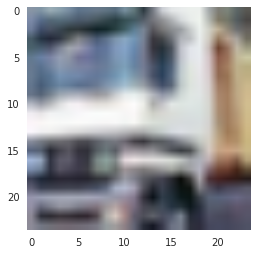

In [12]:
image_tensor = tf.convert_to_tensor(arr)
image_tensor = tf.random_crop(image_tensor, [24, 24, 3])
evaluated_tensor = image_tensor.eval()
imgplot = plt.imshow(evaluated_tensor)

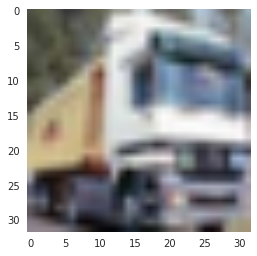

In [13]:
plt.imshow(tf.image.flip_left_right(arr).eval())

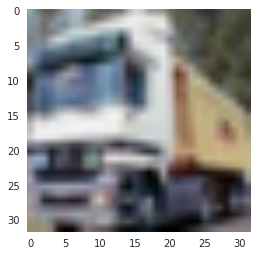

In [14]:
#max_delta should be in the range [0,1), see adjust_brightness https://www.tensorflow.org/api_docs/python/tf/image/adjust_brightness
plt.imshow(tf.image.random_brightness(arr, max_delta=0.5).eval()) 

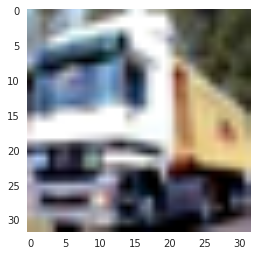

In [15]:
plt.imshow(tf.image.random_contrast(arr, lower=0.2, upper=1.8).eval())

# Exercise
Experiment with the image ops here https://www.tensorflow.org/api_docs/python/tf/image

# Reading in an image
For testing, you might want to try reading an image with mpimg.imread. Here we read an image with matplotlib and use nearest neighbor interpolation to resize it.

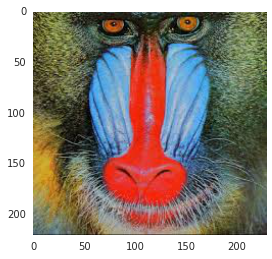

In [16]:
img= mpimg.imread('mandrill.jpg') 
imgplot = plt.imshow(img)

In [26]:
cropped = tf.image.resize_image_with_crop_or_pad(img, 220,220)
imgplot = plt.imshow(tf.image.resize_nearest_neighbor([cropped], [32,32] ).eval())

array([[[[ 38,  34,   0],
         [ 88,  90,  43],
         [ 91,  97,  37],
         ..., 
         [ 82,  91,  46],
         [ 82,  93,  37],
         [ 58,  64,  38]],

        [[ 51,  48,   3],
         [114, 119,  55],
         [148, 155,  88],
         ..., 
         [ 64,  73,  28],
         [130, 139,  94],
         [140, 152,  86]],

        [[127, 126,  69],
         [ 90,  92,  42],
         [107, 116,  37],
         ..., 
         [113, 122,  77],
         [110, 120,  70],
         [136, 145, 100]],

        ..., 
        [[135, 143, 122],
         [142, 144, 105],
         [142, 113,  55],
         ..., 
         [ 82,  76,  52],
         [ 75,  78,  57],
         [ 75,  85,  74]],

        [[108, 123, 118],
         [105, 111,  85],
         [125, 126,  68],
         ..., 
         [ 90,  83,  64],
         [ 88,  87,  67],
         [ 84,  88,  89]],

        [[ 94, 115, 110],
         [100, 117, 107],
         [103, 125, 122],
         ..., 
         [ 63,  64,  46],
  

# Exercise
Read an image of your own with matplotlib and try some of the image ops on it.

# Reading image files using a Queue
Tensorflow allows you to define input pipelines instead of feeding the data during each step. `tf.train.string_input_producer` turns a list of filenames into a FIFO queue from which a reader can pull them. You should call `tf.train.start_queue_runners` to populate the queue before you try to read from it.

In [264]:
filenames = ['Lenna.jpg', 'Fabio.jpg']
filename_queue = tf.train.string_input_producer(filenames) #  list of files to read

reader = tf.WholeFileReader()
key, value = reader.read(filename_queue)

img = tf.image.decode_jpeg(value) # use png or jpg decoder based on your files.
img_arr = []
init = tf.global_variables_initializer()
with tf.Session() as sess2:
  sess2.run(init)

  # Start populating the filename queue.
  coord = tf.train.Coordinator()
  threads = tf.train.start_queue_runners(coord=coord)

  for i in range(len(filenames)):
    arr = img.eval()
    img_arr.append(arr) 
    print("arr.shape : " + str(arr.shape))

  coord.request_stop()
  coord.join(threads)

arr.shape : (400, 400, 3)
arr.shape : (257, 271, 3)


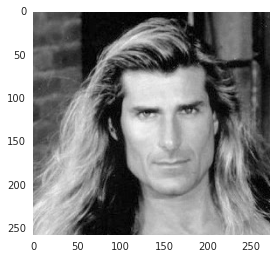

In [266]:
plt.imshow(img_arr[1])

# Exercise
Try using a larger queue of images and applying distortions to them.

# Train the cifar10 model


In [2]:
!ls cifar10

config.yaml  predict_test.json	README.md  setup.py  trainer


In [4]:
%%bash
cd cifar10
export TF_CONFIG='{"task":{"type":"master"}}'
python -m trainer.task

> /home/jaraneta/thinking_machines/dost_workshop/deeplearningworkshop/cifar10/trainer/task.py(157)main()
-> if not tf_config:
(Pdb) 


Traceback (most recent call last):
  File "/home/jaraneta/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/jaraneta/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/jaraneta/thinking_machines/dost_workshop/deeplearningworkshop/cifar10/trainer/task.py", line 178, in <module>
    tf.app.run()
  File "/home/jaraneta/anaconda3/lib/python3.6/site-packages/tensorflow/python/platform/app.py", line 48, in run
    _sys.exit(main(_sys.argv[:1] + flags_passthrough))
  File "/home/jaraneta/thinking_machines/dost_workshop/deeplearningworkshop/cifar10/trainer/task.py", line 157, in main
    if not tf_config:
  File "/home/jaraneta/thinking_machines/dost_workshop/deeplearningworkshop/cifar10/trainer/task.py", line 157, in main
    if not tf_config:
  File "/home/jaraneta/anaconda3/lib/python3.6/bdb.py", line 48, in trace_dispatch
    return self.dispatch_line(frame)
  File "/home/jaraneta/anac

Interrupt execution after 10 minutes

In [69]:
from google.datalab.ml import *
tb_id = TensorBoard.start('/tmp/cifar10/train')

TensorBoard was started successfully with pid 5772. Click here to access it.